# Estimate a Linear Model for COVID-19 Growth in BC

Data from: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline

## Download Data

In [2]:
site_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
data_dir = "csse_covid_19_data/csse_covid_19_time_series/"
filename = "time_series_19-covid-Confirmed.csv"

url = site_url + data_dir + filename
df = pd.read_csv(url, index_col=['Province/State', 'Country/Region'])

# Remove the Lat/Long data
lat_long = df[['Lat', 'Long']]
df = df.drop(['Lat', 'Long'], axis=1)

# Change remaining column labels to dates
df.columns = pd.to_datetime(df.columns)

# Swap index levels so country is first
df = df.swaplevel(0, 1)

df.shape

(487, 61)

In [3]:
df.head()

,,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22
Country/Region,Province/State,,,,,,,,,,,,,,,,,,,,,
Thailand,NaN,2,3,5,7,8,8,14,14,14,19,...,75,82,114,147,177,212,272,322,411,599
Japan,NaN,2,1,2,2,4,4,7,7,11,15,...,701,773,839,825,878,889,924,963,1007,1086
Singapore,NaN,0,1,3,3,4,5,7,7,10,13,...,200,212,226,243,266,313,345,385,432,455
Nepal,NaN,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2
Malaysia,NaN,0,0,0,3,4,4,4,7,8,8,...,197,238,428,566,673,790,900,1030,1183,1306


## Select Data for One Country

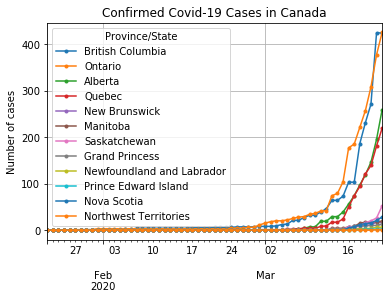

In [4]:
country = "Canada"
country_data = df.loc[country]
country_data.T.plot(style='.-')
plt.grid()
plt.ylabel("Number of cases")
plt.title(f"Confirmed Covid-19 Cases in {country}")
plt.show()

## Select Data for One Province/State

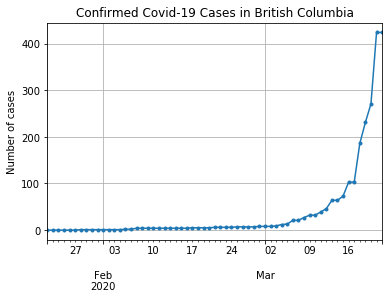

In [5]:
province = "British Columbia"
prov_data = df.loc[(country, province)]
prov_data.plot(style='.-')
plt.ylabel("Number of cases")
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.show()

## Approach 1 - Fit a linear model using least squares

In [6]:
prov_data.head()

2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
Name: (Canada, British Columbia), dtype: int64

In [7]:
# Choose start date for estimation data
start_date = '2020-03-01'
data = prov_data.loc[start_date:].values.reshape(-1, 1)
index = prov_data.loc[start_date:].index[1:]

# Prepare input and output data matrices
M = data[:-1]
y = data[1:]
n = len(y)
assert M.shape == (n, 1)
assert y.shape == (n, 1)
print(f"{n} data points")

21 data points


In [8]:
pd.DataFrame({
    'M': M.reshape(-1),
    'y': y.reshape(-1),
    'y/M': (y/M).reshape(-1)
}, index=index).head()

,M,y,y/M
2020-03-02,8,8,1.000000
2020-03-03,8,9,1.125000
2020-03-04,9,12,1.333333
2020-03-05,12,13,1.083333
2020-03-06,13,21,1.615385


In [9]:
# Compute parameter vector using least squares
# ('@' is matrix multiplication operator in Python > 3.4)
a = np.linalg.inv(M.T @ M) @ M.T @ y
a

array([[1.18795719]])

In [10]:
# Sum of residuals - should be close to zero
np.sum(M*a - y)

-80.12050368617602

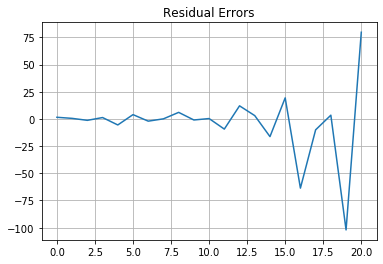

In [11]:
plt.plot(M*a - y)
plt.title('Residual Errors')
plt.grid()

In [12]:
# WARNING: Residuals are not evenly distributed!

In [13]:
# MSE
np.mean((M*a - y)**2)

1043.1232266998547

In [14]:
# Choose prediction horizon
end_date = '2020-03-31'
n_pred = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days

# Make predictions with model
x = np.zeros((1, n_pred + 1))
x[:, 0] = M[0]
for k in range(1, n_pred + 1):
    x[:, k] = a*x[:, k-1]

pred_index = pd.Index(pd.date_range(start_date, end_date))
predictions = pd.Series(x.reshape(-1,), index=pred_index)

# MSE of predictions (they are sensitive to initial x)
np.mean((x[:, 1:n+1].T - M*a)**2)

2612.822399845856

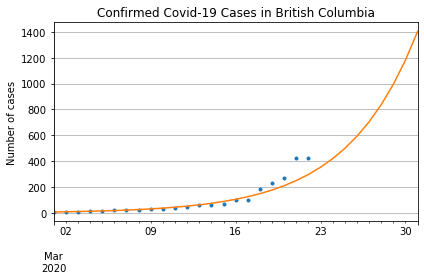

In [15]:
prov_data.loc[start_date:].plot(style='.', label='observed data')
predictions.plot(style='-', label='prediction')
plt.ylabel("Number of cases")
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.tight_layout()
plt.savefig('covid_growth_bc.png')
plt.show()

In [16]:
predictions.tail()

2020-03-27     704.547902
2020-03-28     836.972745
2020-03-29     994.287789
2020-03-30    1181.171326
2020-03-31    1403.180968
Freq: D, dtype: float64

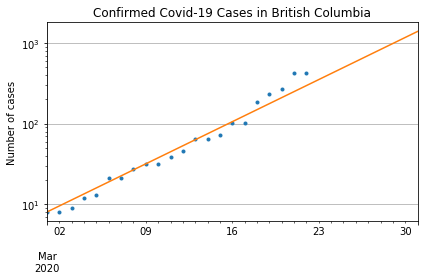

In [17]:
prov_data.loc[start_date:].plot(style='.', label='observed data')
predictions.plot(style='-', label='prediction')
plt.ylabel("Number of cases")
plt.yscale('log')
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.tight_layout()
plt.savefig('covid_growth_bc_log.png')
plt.show()

In [18]:
# This model is biased towards fitting to recent growth rates

## Approach 2 - Fit a linear model to the log of observations

In [19]:
# Choose start date for estimation data
start_date = '2020-03-01'
data = pd.DataFrame({
        'Cases': prov_data.loc[start_date:].values
    },
    index = prov_data.loc[start_date:].index
)
data['log(Cases)'] = np.log(data['Cases'])

# Prepare input and output data matrices
M = data['log(Cases)'][:-1].values.reshape(-1, 1)
y = data['log(Cases)'][1:].values.reshape(-1, 1)
n = len(y)
assert M.shape == (n, 1)
assert y.shape == (n, 1)
print(f"{n} data points")

21 data points


In [20]:
pd.DataFrame({
    'M': M.reshape(-1),
    'y': y.reshape(-1),
    'y - M': (y - M).reshape(-1)
}, index=index).head()

,M,y,y - M
2020-03-02,2.079442,2.079442,0.000000
2020-03-03,2.079442,2.197225,0.117783
2020-03-04,2.197225,2.484907,0.287682
2020-03-05,2.484907,2.564949,0.080043
2020-03-06,2.564949,3.044522,0.479573


In [21]:
# Compute parameter vector using least squares
# ('@' is matrix multiplication operator in Python > 3.4)
a = np.linalg.inv(M.T @ M) @ M.T @ y
a

array([[1.04704218]])

In [22]:
# Sum of residuals - should be close to zero
np.sum(M*a - y)

-0.23456813357758222

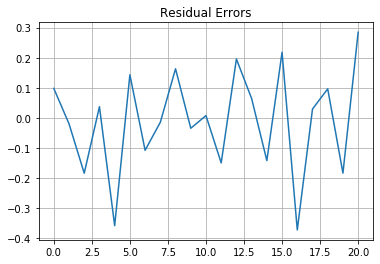

In [23]:
plt.plot(M*a - y)
plt.title('Residual Errors')
plt.grid()

In [24]:
# Looks better...

In [25]:
# MSE
np.mean((np.exp(M*a) - np.exp(y))**2)

1425.0547903494023

In [26]:
# Choose prediction horizon
end_date = '2020-03-31'
n_pred = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days

# Make predictions with model
x = np.zeros((1, n_pred + 1))
x[:, 0] = M[0]
for k in range(1, n_pred + 1):
    x[:, k] = a*x[:, k-1]

pred_index = pd.Index(pd.date_range(start_date, end_date))
predictions = pd.Series(x.reshape(-1,), index=pred_index)

# MSE of predictions (they are sensitive to initial x)
x_true = x[:, 1:n+1].T
np.mean((x_true - M*a)**2)

0.20836435537557554

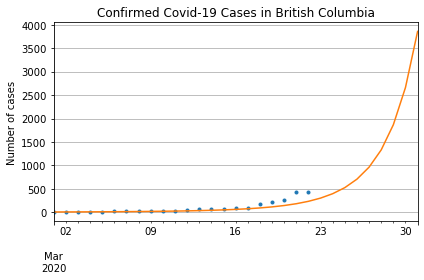

In [27]:
prov_data.loc[start_date:].plot(style='.', label='observed data')
np.exp(predictions).plot(style='-', label='prediction')
plt.ylabel("Number of cases")
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.tight_layout()
plt.savefig('covid_growth_bc_2.png')
plt.show()

In [28]:
np.exp(predictions).tail()

2020-03-27     963.841200
2020-03-28    1331.617832
2020-03-29    1867.915486
2020-03-30    2662.250946
2020-03-31    3858.159353
Freq: D, dtype: float64

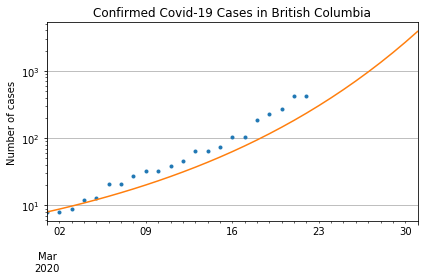

In [29]:
prov_data.loc[start_date:].plot(style='.', label='observed data')
np.exp(predictions).plot(style='-', label='prediction')
plt.ylabel("Number of cases")
plt.yscale('log')
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.tight_layout()
plt.savefig('covid_growth_bc_2_log.png')
plt.show()

In [30]:
# Model prediction curve looks the right shape but initial condition
# is biasing the overall trajectory

## Approach 3 - Fit a linear model using numerical optimization

In [52]:
# Choose start date for estimation data
start_date = '2020-03-01'
data = pd.DataFrame(
    {'Cases': prov_data.loc[start_date:].values},
    index = prov_data.loc[start_date:].index
)
data['log(Cases)'] = np.log(data['Cases'])
data.head()

,Cases,log(Cases)
2020-03-01,8,2.079442
2020-03-02,8,2.079442
2020-03-03,9,2.197225
2020-03-04,12,2.484907
2020-03-05,13,2.564949


In [61]:
# Initial condition and data to predict
label = 'Cases'
x0 = data.loc[start_date, label]
x_true = data[label][1:]
x_true.head()

2020-03-02     8
2020-03-03     9
2020-03-04    12
2020-03-05    13
2020-03-06    21
Name: Cases, dtype: int64

In [65]:
def predict(a, x0, nt):
    """Predicts trajectory of x for n timesteps given x[0] = x0
    and x[k+1] = a*x[k].
    """
    return x0 * np.cumprod(np.repeat(a, nt))

# Example
a = 1.2
x0 = 8
nt = 10
predict(a, x0, nt)

array([ 9.6       , 11.52      , 13.824     , 16.5888    , 19.90656   ,
       23.887872  , 28.6654464 , 34.39853568, 41.27824282, 49.53389138])

In [76]:
def mse(y, y_true):
    """Mean squared error of predictions compared to true values.
    """
    return np.mean((y - y_true)**2)

def cost_function(params, x_true):
    """Cost function to minimize.
    
    Args:
        params (tuple): Unknown variables (a, x0) to optimize.
        x_true (array): Data points to fit model to.
    """
    a, x0 = params
    x_pred = predict(a, x0, len(x_true))
    return mse(x_pred, x_true)

In [77]:
# Test
params = (a, x0)
cost_function(params, x_true)

366.0661943364508

In [78]:
# Initial guess
x0 = (1.2, 8)

# Minimize cost function
res = minimize(cost_function, x0, args=(x_true))

print(res.message)
#assert res.status == 0

a, x0 = res.x
a, x0

Desired error not necessarily achieved due to precision loss.


(1.265849955827241, 3.2357696682614563)

In [79]:
# Choose prediction horizon
end_date = '2020-03-31'
n_pred = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days

# Make predictions with model
x_pred = np.zeros(n_pred + 1)
x_pred[0] = x0
x_pred[1:] = predict(a, x0, n_pred)

pred_index = pd.Index(pd.date_range(start_date, end_date))
predictions = pd.Series(x_pred, index=pred_index)

# MSE of predictions (they are sensitive to initial x)
np.mean((x_true - x_pred[:len(x_true)])**2)

1533.341518832598

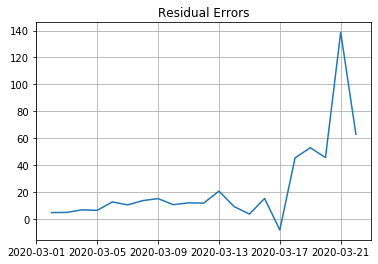

In [81]:
plt.plot(x_true - x_pred[:len(x_true)])
plt.title('Residual Errors')
plt.grid()

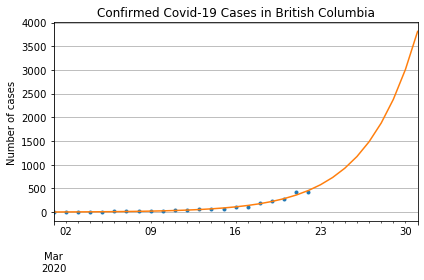

In [82]:
prov_data.loc[start_date:].plot(style='.', label='observed data')
predictions.plot(style='-', label='prediction')
plt.ylabel("Number of cases")
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.tight_layout()
plt.savefig('covid_growth_bc_3.png')
plt.show()

In [83]:
predictions.tail()

2020-03-27    1485.646897
2020-03-28    1880.606058
2020-03-29    2380.565096
2020-03-30    3013.438222
2020-03-31    3814.560640
Freq: D, dtype: float64

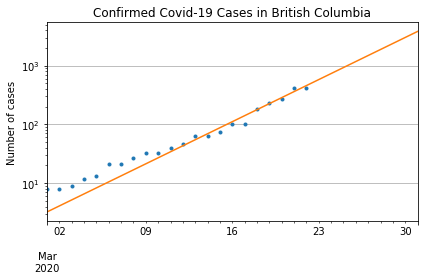

In [84]:
prov_data.loc[start_date:].plot(style='.', label='observed data')
predictions.plot(style='-', label='prediction')
plt.ylabel("Number of cases")
plt.yscale('log')
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.tight_layout()
plt.savefig('covid_growth_bc_3_log.png')
plt.show()

In [86]:
# This model is also biased toward minimizing the 
# MSE for higher case counts (more recent data)